# Dynamic time warping (DTW)



"In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences which may vary in time or speed. For instance, similarities in walking patterns could be detected using DTW, even if one person was walking faster than the other, or if there were accelerations and decelerations during the course of an observation."

The objective of time series comparison methods is to produces a distance metric between two input time series. Dynamic time warping is a seminal time series comparison technique that has been used for speech recognition and word recognition since the 1970s with sound waves as the source; an often cited paper is Dynamic time warping for isolated word recognition based on ordered graph searching techniques. 

This technique can not only be used for pattern matching but also anomaly detection (e.g. overlap time series between two disjoint time periods to understand if the shape has changed significantly, examine outliers). For example, when looking at the red and blue lines in the graph to the right, note the traditional time series matching (i.e. Euclidean Matching) is extremely restrictive. On the otherhand, dynamic time warping allows the two curves to match up even though the x-axis (i.e. time) are not necessarily in sync. Another way is to think of this as a robust dissimilarlity score where lower number means the series are more similar. 

Two time series (the base time series and new time series) are considered similar when it is possible to map with function f(x) according to the following rules so as to match the magnitudes using an optimal (warping) path. 

For example, let's assume that you have just recorded yourself saying a word and try to match it against another instance. The signals look similar, but have varying lengths and different activations for different features. So, how do you decide the similarity. Dynamic time warping (DTW) is probably something which can come to your rescue. Quoting wikipedia:



<img src="./figs/Euclidean_vs_DTW.jpg" alt="Alt text that describes the graphic" title="Title text" width="300" height="400" ALIGN=left/>


In this exercise I will try and put forward a naive implementation of DTW and also explain the different pieces of the problem.

#### Customary imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Creating two signals

In [5]:
x = np.array([1, 1, 2, 3, 2, 0])
y = np.array([0, 1, 1, 2, 3, 2, 1])

#### Plotting the two signals

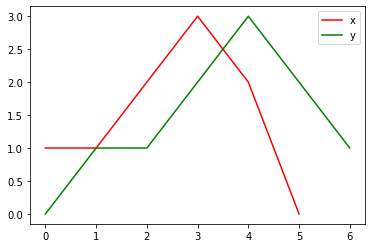

In [6]:
plt.plot(x,'r', label='x')
plt.plot(y, 'g', label='y')
plt.legend();

So, it appears that both the signals show similar behaviour: they both have a peak and around the peak they slop downwards. They vary in their speed and total duration. So, all set for DTW.

#### Aim

Our aim is to find a mapping between all points of x and y. For instance, x(3) may be mapped to y(4) and so on.

#### Making a 2d matrix to compute distances between all pairs of x and y

In this initial step, we will find out the distance between all pair of points in the two signals. Lesser distances implies that these points may be candidates to be matched together.

In [7]:
distances = np.zeros((len(y), len(x)))

In [8]:
distances

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

We will use euclidean distance between the pairs of points.

In [9]:
for i in range(len(y)):
    for j in range(len(x)):
        distances[i,j] = (x[j]-y[i])**2  

In [10]:
distances

array([[1., 1., 4., 9., 4., 0.],
       [0., 0., 1., 4., 1., 1.],
       [0., 0., 1., 4., 1., 1.],
       [1., 1., 0., 1., 0., 4.],
       [4., 4., 1., 0., 1., 9.],
       [1., 1., 0., 1., 0., 4.],
       [0., 0., 1., 4., 1., 1.]])

#### Visualizing the distance matrix

We will write a small function to visualize the distance matrix we just created.

In [11]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();


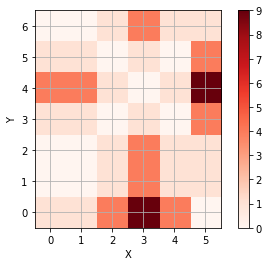

In [12]:
distance_cost_plot(distances)

From the plot above, it seems like the diagonal entries have low distances, which means that the distance between similar index points in x and y is low.

#### Warping path

In order to create a mapping between the two signals, we need to create a path in the above plot. The path should start at (0,0) and want to reach (M,N) where (M, N) are the lengths of the two signals. Our aim is to find the path of minimum distance. To do this, we thus build a matrix similar to the distances matrix. This matrix would contain the minimum distances to reach a specific point when starting from (0,0). We impose some restrictions on the paths which we would explore:
1. The path must start at (0,0) and end at (M,N)
2. We cannot go back in time, so the path only flows forwards, which means that from a point (i, j), we can only right (i+1, j)  or upwards (i, j+1) or diagonal (i+1, j+1).

These restrictions would prevent the combinatorial explosion and convert the problem to a Dynamic Programming problem  which can be solved in O(MN) time.

In [13]:
accumulated_cost = np.zeros((len(y), len(x)))

#### Let us now build up the accumulated cost

* Since we start from (0,0), the accumulated cost at this point is distance(0,0)

In [14]:
accumulated_cost[0,0] = distances[0,0]

Lets see how accumulated cost looks at this point.

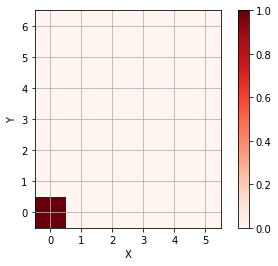

In [15]:
distance_cost_plot(accumulated_cost)

* If we were to move along the first row, i.e. from (0,0) in the right direction only, one step at a time

In [16]:
for i in range(1, len(x)):
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1]    

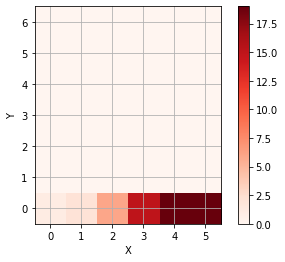

In [17]:
distance_cost_plot(accumulated_cost)

* If we were to move along the first column, i.e. from (0,0) in the upwards direction only, one step at a time

In [18]:
for i in range(1, len(y)):
    accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]    

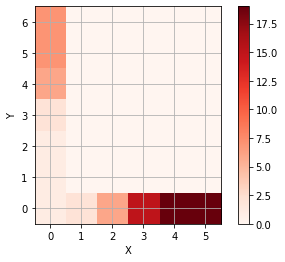

In [19]:
distance_cost_plot(accumulated_cost)

* For all other elements, we have $ \mathrm{Accumulated\ Cost\ (D (i, j)) = \min\{{D(i-1, j-1), D(i-1, j), D(i, j-1)}\} + distance(i, j)}$

In [20]:
for i in range(1, len(y)):
    for j in range(1, len(x)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

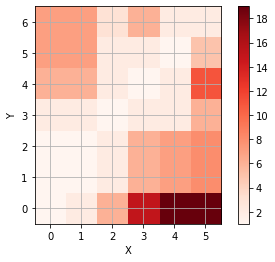

In [21]:
distance_cost_plot(accumulated_cost)

So, now we have obtained the matrix containing cost of all paths starting from (0,0). We now need to find the path minimizing the distance which we do by backtracking.

#### Backtracking and finding the optimal warp path

Backtracking procedure is fairly simple and involves trying to move back from the last point (M, N) and finding which place we would reached there from (by minimizing the cost) and do this in a repetitive fashion.

In [22]:
path = [[len(x)-1, len(y)-1]]
i = len(y)-1
j = len(x)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [23]:
path

[[5, 6], [4, 5], [3, 4], [2, 3], [1, 2], [1, 1], [0, 1], [0, 0]]

In [24]:
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]

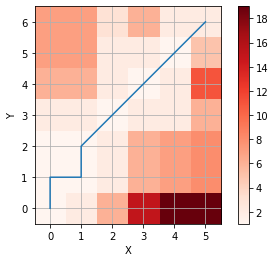

In [25]:
distance_cost_plot(accumulated_cost)
plt.plot(path_x, path_y);

The above plot shows the optimum warping path which minimizes the sum of distance (DTW distance) along the path. Let us wrap up the function by also incorporating the DTW distance between the two signals as well.

In [26]:
def path_cost(x, y, accumulated_cost, distances):
    path = [[len(x)-1, len(y)-1]]
    cost = 0
    i = len(y)-1
    j = len(x)-1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j-1
            else:
                i = i - 1
                j= j- 1
        path.append([j, i])
    path.append([0,0])
    for [y, x] in path:
        cost = cost +distances[x, y]
    return path, cost    

In [27]:
path, cost = path_cost(x, y, accumulated_cost, distances)
print(path)
print(cost)
print(type(cost), type(path))



[[5, 6], [4, 5], [3, 4], [2, 3], [1, 2], [1, 1], [0, 1], [0, 0]]
2.0
<class 'numpy.float64'> <class 'list'>


Here is another implementation from a DTW library to compare the results. It has been transferred into the notebook in order to avoid library installation issues in Jupyter Environment.

In [28]:
from numpy import array, zeros, full, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from math import isinf

def dist_func(a,b,function):
    if function=='euclidean':
        return distance.euclidean(a,b)
    if function=='manhattan':
        return distance.cityblock(a,b)

def dtw(x, y, dist_name, warp=1, w=inf, s=1.0):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    :param int w: window size limiting the maximal distance between indices of matched entries |i,j|.
    :param float s: weight applied on off-diagonal moves of the path. As s gets larger, the warping path is increasingly biased towards the diagonal
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    assert isinf(w) or (w >= abs(len(x) - len(y)))
    assert s > 0
    r, c = len(x), len(y)
    if not isinf(w):
        D0 = full((r + 1, c + 1), inf)
        for i in range(1, r + 1):
            D0[i, max(1, i - w):min(c + 1, i + w + 1)] = 0
        D0[0, 0] = 0
    else:
        D0 = zeros((r + 1, c + 1))
        D0[0, 1:] = inf
        D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            if (isinf(w) or (max(0, i - w) <= j <= min(c, i + w))):
                D1[i, j] = dist_func(x[i], y[j],dist_name)
    C = D1.copy()
    jrange = range(c)
    for i in range(r):
        if not isinf(w):
            jrange = range(max(0, i - w), min(c, i + w + 1))
        for j in jrange:
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r)
                j_k = min(j + k, c)
                min_list += [D0[i_k, j] * s, D0[i, j_k] * s]
            D1[i, j] += min(min_list)
    if len(x) == 1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1], C, D1, path

def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j + 1], D[i + 1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

Let us compare our naive implementation with that of [mlpy](http://mlpy.sourceforge.net/) which also provides a DTW implementation.

In [29]:
# from scipy.spatial.distance import euclidean
# import numpy as np


dist, cost, acc_cost_matrix, path = dtw(x, y, dist_name='euclidean')

print(dist)







2.0


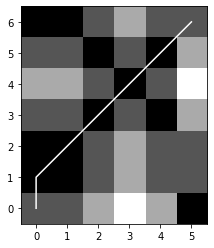

In [30]:
import matplotlib.cm as cm
fig = plt.figure(1)
ax = fig.add_subplot(111)
plot1 = plt.imshow(cost.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plot2 = plt.plot(path[0], path[1], 'w')
xlim = ax.set_xlim((-0.5, cost.shape[0]-0.5))
ylim = ax.set_ylim((-0.5, cost.shape[1]-0.5))

The path looks almost identical to the one we got. Sometimes, there can be a slight difference which can happen due to the fact that the path chosen by different implementations.

In [31]:
dist

2.0

Not bad! Our implementation gets the same distance between x and y. 

Let us look at another interesting way to visualize the warp. We will place the two signals on the same axis and 

5 0 : 6 1
4 2 : 5 2
3 3 : 4 3
2 2 : 3 2
1 1 : 2 1
1 1 : 1 1
0 1 : 1 1
0 1 : 0 0


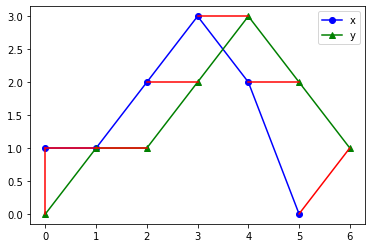

In [32]:
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    print(map_x, x[map_x], ":", map_y, y[map_y])
    
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

The above plot shows the mapping between the two signal. The red lines connect the matched points which are given by the DTW algorithm Looks neat isn't it? Now, let us try this for some known signal. This example is inspired from the example used in R's dtw implementation. We will see the DTW path between a sine and cosine on the same angles. 

In [33]:
idx = np.linspace(0, 6.28, 100)

In [34]:
x = np.sin(idx)

In [35]:
y = np.cos(idx)

In [36]:
distances = np.zeros((len(y), len(x)))

In [37]:
for i in range(len(y)):
    for j in range(len(x)):
        distances[i,j] = (x[j]-y[i])**2  

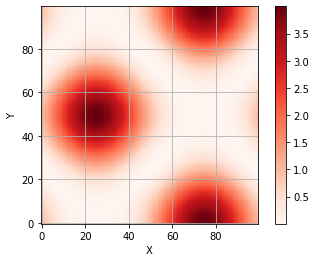

In [38]:
distance_cost_plot(distances)

In [39]:
accumulated_cost = np.zeros((len(y), len(x)))
accumulated_cost[0,0] = distances[0,0]
for i in range(1, len(y)):
    accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]
for i in range(1, len(x)):
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1] 
for i in range(1, len(y)):
    for j in range(1, len(x)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]

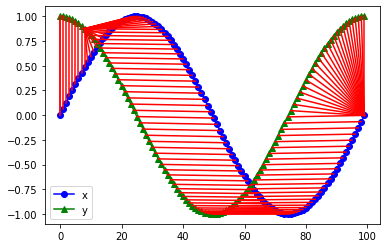

In [40]:
plt.plot(x, 'bo-' ,label='x')
plt.plot(y, 'g^-', label = 'y')
plt.legend();
paths = path_cost(x, y, accumulated_cost, distances)[0]
for [map_x, map_y] in paths:
    #print map_x, x[map_x], ":", map_y, y[map_y]
    
    plt.plot([map_x, map_y], [x[map_x], y[map_y]], 'r')

Ok, this does look nice. I am impressed!

# Speech Matching Scenario

One of the most common use cases for dynamic time warping is the speech matching scenario. In our use case, we will be matching various audio recordings (in WAV files) based on quotes from <a href="https://www.amazon.com/The-Expanse-Season-1/dp/B018BZ3SCM">The Expanse</a>. There are four audio clips (you can listen to them below but this is not necessary) where three of them (clips 1, 2, and 4) are based on the quote 

- "Doors and corners, kid. That's where they get you"

and one clip (clip 3) is the quote 

- "You walk into a room too fast, the room eats you"

In [52]:

from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import librosa
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# Read stored audio files for comparison
fs1, data1 = wavfile.read("doors-and-corners-kid_thats-where-they-get-you.wav")
fs2, data2 = wavfile.read("doors-and-corners-kid_thats-where-they-get-you-2.wav")
fs3, data3 = wavfile.read("you-walk-into-a-room-too-fast_the-room-eats-you.wav")
fs4, data4 = wavfile.read("doors-and-corners-kid.wav")

y1, sr1 = librosa.load("doors-and-corners-kid_thats-where-they-get-you.wav")
y2, sr2 = librosa.load("doors-and-corners-kid_thats-where-they-get-you-2.wav")
y3, sr3 = librosa.load("you-walk-into-a-room-too-fast_the-room-eats-you.wav")
y4, sr4 = librosa.load("doors-and-corners-kid.wav")
mfcc1 = librosa.feature.mfcc(y1, sr1, n_mfcc=13)
mfcc2 = librosa.feature.mfcc(y2, sr2, n_mfcc=13)
mfcc3 = librosa.feature.mfcc(y3, sr3, n_mfcc=13)
mfcc4 = librosa.feature.mfcc(y4, sr4, n_mfcc=13)

# Take the max values along axis
data1 = np.amax(data1, axis=1)
data2 = np.amax(data2, axis=1)
data3 = np.amax(data3, axis=1)
data4 = np.amax(data4, axis=1)




## Audio Visualizations


Below are visualizations using matplotlib of the four audio clips:

- Clip 1: This is our base time series based on the quote Doors and corners, kid. That's where they get you.
- Clip 2: This is a new time series [v2] based on clip 1 where the intonation and speech pattern is extremely exagerated.
- Clip 3: This is another time series that's based on the quote You walk into the room too fast, the room eats you. with the same intonation and speed as Clip 1.
- Clip 4: This is a new time seris [v3] based on clip 1 where the intonation and speech pattern is similar to clip 1.

In [53]:
print(fastdtw(data1, data4)[0])
print(mfcc1)

287169343.0
[[-4.4410733e+02 -4.4045969e+02 -4.3955103e+02 ... -4.8927002e+02
  -4.7874133e+02 -4.7540195e+02]
 [ 9.6404495e+01  9.7667480e+01  9.4557281e+01 ...  1.0884208e+02
   1.1777818e+02  1.2089142e+02]
 [-6.4998498e+00 -3.9463930e+00  4.5415771e-01 ...  2.4505779e+01
   2.0470930e+01  1.7599964e+01]
 ...
 [-8.0519390e+00 -9.4778557e+00 -9.9958620e+00 ... -1.5128503e+00
  -6.9647942e+00 -5.7556410e+00]
 [-1.3360493e+01 -9.4246006e+00 -6.6845503e+00 ... -4.8580551e+00
  -4.8854885e+00 -1.2630914e+00]
 [-1.5032785e+00  1.5963273e+00 -1.8858148e+00 ... -8.9750898e-01
   3.8760593e+00  5.5946484e+00]]


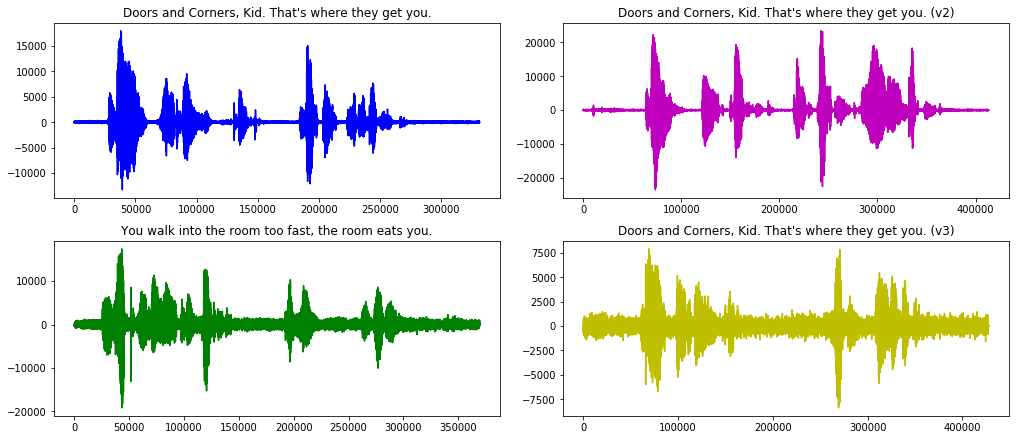

In [54]:
fig, axs = plt.subplots(2, 2,figsize=(14,6),constrained_layout=True)
axs[0, 0].plot(data1,'b')
axs[0, 0].set_title("Doors and Corners, Kid. That's where they get you.")
axs[0, 1].plot(data2,'m')
axs[0, 1].set_title("Doors and Corners, Kid. That's where they get you. (v2)")
axs[1, 0].plot(data3,'g')
axs[1, 0].set_title("You walk into the room too fast, the room eats you.")
axs[1, 1].plot(data4,'y')
axs[1, 1].set_title("Doors and Corners, Kid. That's where they get you. (v3)")

plt.show()

When comparing two audio clips (in this example, clips 1 and 4), 
notice how even though both clips have the same intonation and words, the times are not in sync. 
<img src="./figs/dtw-animated.gif" alt="Alt text that describes the graphic" title="Title text" width="500" height="700" /> 




If we folllow Euclidian Matching approach the magnitude of the base and new time series are not in sync. 
But by using dynamic time warping, the time series (x-axis) is shifted to sync the two clips.

<img src="./figs/dynamic-time-warping.png" alt="Alt text that describes the graphic" title="Title text" width="500" height="700" /> 


Comparing Clip 1 and Clip 2
Comparing the base time series (blue) with a new time series [v2] (magenta) of the same quote where the intonation and speed differnces are exagerated.

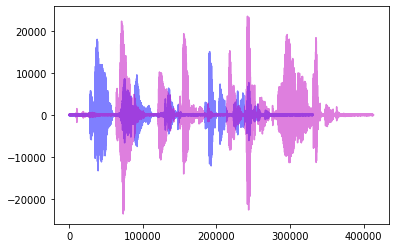

In [55]:
plt.plot(data1,'b', alpha=0.5)
plt.plot(data2,'m', alpha=0.5)

plt.show()

## Distance between clip 1 and clip 2


In [56]:
fastdtw(data1, data2)[0]

471222169.0

### Comparing Clip 1 and Clip 3
Comparing the base time series (blue) with a new time series (green) with different quotes but where the intonation and speed differnces are the same.

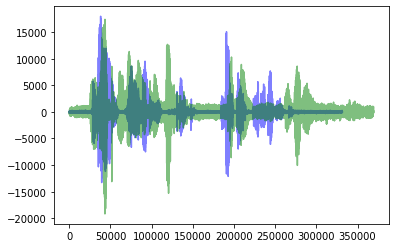

In [57]:
plt.plot(data1,'b', alpha=0.5)
plt.plot(data3,'g', alpha=0.5)

plt.show()

## Distance between clip 1 and clip 3

In [58]:

fastdtw(data1, data3)[0]

298533012.0

## Comparing Clip 1 and Clip 4
Comparing the base time series (blue) with a new time series [v3] (yellow) with the same quote and where the intonation and speed differences are the same.

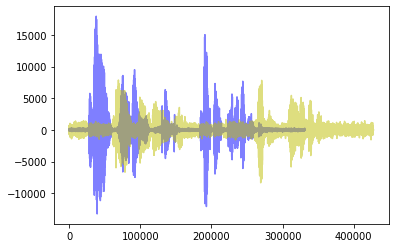

In [59]:
plt.plot(data1,'b', alpha=0.5)
plt.plot(data4,'y', alpha=0.5)

plt.show()

In [60]:
fastdtw(data1, data4,dist=euclidean)[0]

287169343.0

In [61]:
fastdtw(data1, data4)[0]

287169343.0

## Discussion

By using fastdtw, we can quickly calculate the distance between two different time series - in this case audio patterns.
Base	Query	Distance

- Distance between Clip 1 and Clip 2 is 471222169.0
- Distance between Clip 1 and Clip 3 is 298533012.0
- Distance between Clip 1 and Clip 4 is 287169343.0


Some quick observations:
- Clips 1 and 4 have the shortest distance as the audio clips have the same words and intonations
- The distance between Clips 1 and 3 is also quite short (though longer than when compared to Clip 4) even though they have different words, they are using the same intonation and speed.
- Clips 1 and 2 have the longest distance due to the extremely exagerated intonation and speed even though they are using the same quote.

As you can see, one can use dynamic time warping to ascertain the similarity of two different time series.

In [62]:
from scipy.spatial.distance import euclidean
print("Euclidean distance between Clip 1 and Clip 2",euclidean(data1,data2[0:len(data1)]))
print("Euclidean distance between Clip 1 and Clip 3",euclidean(data1,data3[0:len(data1)]))
print("Euclidean distance between Clip 1 and Clip 4",euclidean(data1,data4[0:len(data1)]))

Euclidean distance between Clip 1 and Clip 2 1787245.2383198563
Euclidean distance between Clip 1 and Clip 3 1335929.394595388
Euclidean distance between Clip 1 and Clip 4 1063362.306238095


#### Conclusions

We worked out a naive DTW implementation pretty much from scratch. It seems to do reasonably well on artificial data and real world audio data.

#### References

1. [Wikipedia page on dtw](http://en.wikipedia.org/wiki/Dynamic_time_warping)
2. [R's dtw package](http://dtw.r-forge.r-project.org/)
3. [mlpy page on dtw](http://mlpy.sourceforge.net/docs/3.4/dtw.html)
4. [DTW review paper](http://www2.hawaii.edu/~senin/assets/papers/DTW-review2008draft.pdf)
5. [Stan Salvador, and Philip Chan. "FastDTW: Toward accurate dynamic time warping in linear time and space." Intelligent Data Analysis 11.5 (2007): 561-580.](http://cs.fit.edu/~pkc/papers/tdm04.pdf)
